### Download data

We will download data from NYU box and extract it to local disk. It may take a couple of minutes

In [1]:
str_path = "./weather/"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from sklearn import linear_model

np.random.seed(2019)

In [3]:
def extract_temp(file_name,col_ind):
    data_aux = np.loadtxt(file_name, usecols=range(10))
    data = data_aux[:,col_ind]
    err_count = 0
    ind_errs = []
    for ind in range(data.shape[0]):
        if data[ind] > 100 or data[ind] < -100:
            err_count = err_count + 1
            ind_errs.append(ind)
            data[ind] = data[ind-1]  
    print("File name: " + file_name)
    print("Errors: " + str(err_count) + " Indices: " + str(ind_errs))
    return data

def create_data_matrix(str_path):
    file_name_list = listdir(str_path)
    file_name_list.sort()
    col_ind = 8 # 8 = last 5 minutes, 9 = average over the whole hour
    data_matrix = []
    ind = 0
    for file_name in file_name_list:
        if file_name[0] == '.':
            continue
        else:
            print("Station " + str(ind))
            ind = ind + 1
            data_aux = extract_temp(str_path + file_name,col_ind)
            if len(data_matrix) == 0:
                data_matrix = data_aux
            else:
                data_matrix = np.vstack((data_matrix,data_aux))
    return data_matrix.T

In [4]:
load_files = False
if load_files:
    str_path_2015 = str_path + "hourly/2015/"
    data_matrix = create_data_matrix(str_path_2015)
    str_path_2016 = str_path + "hourly/2016/"
    data_matrix_2016 = create_data_matrix(str_path_2016)
else:
    data_matrix = np.load(str_path +"hourly_temperature_2015.npy")
    data_matrix_2016 = np.load(str_path +"hourly_temperature_2016.npy")

file_name_list = listdir(str_path + "hourly/2015/")
file_name_list.sort()

### prepare X and y for training

we select a particular city as response variable. You can find indices for some selected cities in the comments. 

In [5]:
ind_response = 31 # 53 = Manhattan, 18 = Troy has 2 correlated features
# 23 = Williams dense linear model 30 = Death Valley
print("Response is " + str(file_name_list[ind_response]))
y_raw = data_matrix[:,ind_response]
y_2016 = data_matrix_2016[:,ind_response]
ind_X = np.hstack((np.arange(0,ind_response),np.arange(ind_response+1,data_matrix.shape[1])))
X_raw = data_matrix[:,ind_X]
X_2016 = data_matrix_2016[:,ind_X]
n_features = X_raw.shape[1]

Response is CRNH0203-2015-CO_Boulder_14_W.txt


In [6]:
n_train_values = 40
n_test = int(1e3)
n_val = int(1e2)
n_train_max = data_matrix.shape[0] - n_test - n_val
n_train_list = np.around(np.logspace(np.log10(n_features),np.log10(n_train_max),n_train_values))
train_error_vec = []
val_error_vec = []
test_error_vec = []
test_2016_vec = []
train_error_ls_vec = []
test_error_ls_vec = []
test_2016_ls_vec = []
train_error_fixed_n_vec = []
val_error_fixed_n_vec = []
coeffs_ls_matrix = np.zeros((n_features,len(n_train_list)))
coeffs_gd_matrix = np.zeros((n_features,len(n_train_list)))
errs_v = np.zeros((n_features,len(n_train_list)))
k_vec = []
train_error_ridge_vec = []
val_error_ridge_vec = []
test_error_ridge_vec = []
test_2016_ridge_vec = []

In [7]:
n_lambda = 50
lambdas_ridge_aux = np.logspace(-5, 2, n_lambda)

k_max = 50000
alpha = 0.01


In [8]:
coeffs_fixed_n = np.zeros((n_features,k_max))
fixed_n = n_train_list[4]

In [9]:
center_raw = X_raw.mean(axis=0)
X_raw_centered = X_raw - center_raw
col_norms_raw = np.linalg.norm(X_raw_centered, axis=0) / np.sqrt(X_raw.shape[0])
X_raw_norm = np.true_divide(X_raw_centered, col_norms_raw)
true_covariance = np.dot(X_raw_norm.T,X_raw_norm)
v_true, s_true, v_true_h = np.linalg.svd(true_covariance)

In [10]:
i_m = 0
for n_train in n_train_list:
    
    lambdas_ridge = lambdas_ridge_aux * n_train
    
    aux_ind = np.random.permutation(range(data_matrix.shape[0]))
    ind_test = aux_ind[:n_test]
    ind_val = aux_ind[n_test:(n_test+n_val)]
    X_test = X_raw[ind_test,:]
    y_test = y_raw[ind_test]
    X_val = X_raw[ind_val,:]
    y_val = y_raw[ind_val]
    ind_train = aux_ind[(n_test+n_val):int(n_test+n_val+n_train)]
    X_train = X_raw[ind_train,:]
    y_train = y_raw[ind_train]
    
    center_vec = X_train.mean(axis=0)
    X_train_centered = X_train - center_vec
    col_norms = np.linalg.norm(X_train_centered, axis=0) / np.sqrt(n_train)
    X_train_norm = np.true_divide(X_train_centered, col_norms)
    X_test_centered = X_test - center_vec
    X_test_norm = np.true_divide(X_test_centered, col_norms)
    X_val_centered = X_val - center_vec
    X_val_norm = np.true_divide(X_val_centered, col_norms)
    X_2016_centered = X_2016 - center_vec
    X_2016_norm = np.true_divide(X_2016_centered, col_norms)
    y_train_center = y_train.mean()
    y_train_centered = y_train - y_train_center
    norm_y_train = np.linalg.norm(y_train_centered) / np.sqrt(n_train)
    y_train_norm = y_train_centered / norm_y_train
    
    # ridge regression
    coeffs_ini = np.zeros(n_features)
    coeffs = coeffs_ini
    y_val_est = norm_y_train * np.dot(X_val_norm, coeffs) + y_train_center
    min_error_val = np.linalg.norm(y_val - y_val_est) / np.sqrt(len(y_val))
    coeffs_gd_best = coeffs
    
    k_best = 0
    for k in range(1,k_max):
        coeffs = coeffs + alpha * X_train_norm.T @ ( y_train_norm - X_train_norm @ coeffs ) / n_train
        y_val_est = norm_y_train * np.dot(X_val_norm, coeffs) + y_train_center
        error_val = np.linalg.norm(y_val - y_val_est) / np.sqrt(len(y_val))
        if error_val < min_error_val:
            min_error_val = error_val
            k_best = k
            coeffs_gd_best = coeffs
        if n_train == fixed_n:
            y_train_est = norm_y_train * np.dot(X_train_norm, coeffs) + y_train_center
            train_error = np.linalg.norm(y_train - y_train_est) / np.sqrt(len(y_train))
            train_error_fixed_n_vec.append(train_error)
            val_error_fixed_n_vec.append(error_val)
            coeffs_fixed_n[:,k] = coeffs
    k_vec.append(k_best)
    y_train_gd = norm_y_train * np.dot(X_train_norm, coeffs_gd_best) + y_train_center
    y_test_gd = norm_y_train * np.dot(X_test_norm, coeffs_gd_best) + y_train_center
    y_2016_gd = norm_y_train * np.dot(X_2016_norm, coeffs_gd_best) + y_train_center
    train_error_gd = np.linalg.norm(y_train - y_train_gd) / np.sqrt(len(y_train))
    test_error_gd = np.linalg.norm(y_test - y_test_gd) / np.sqrt(len(y_test))
    test_2016_gd = np.linalg.norm(y_2016 - y_2016_gd) / np.sqrt(len(y_2016))
    train_error_vec.append(train_error_gd)
    val_error_vec.append(min_error_val)
    test_error_vec.append(test_error_gd)
    test_2016_vec.append(test_2016_gd)
    coeffs_gd_matrix[:,i_m] = coeffs_gd_best
    
    coeffs_ls = np.linalg.lstsq(X_train_norm, y_train_norm, rcond=None)[0]
    y_train_est = norm_y_train * np.dot(X_train_norm, coeffs_ls) + y_train_center
    y_test_est = norm_y_train * np.dot(X_test_norm, coeffs_ls) + y_train_center
    y_2016_est = norm_y_train * np.dot(X_2016_norm, coeffs_ls) + y_train_center
    train_error = np.linalg.norm(y_train_est - y_train) / np.sqrt(len(y_train))
    test_error = np.linalg.norm(y_test_est - y_test) / np.sqrt(len(y_test))
    test_2016_error = np.linalg.norm(y_2016_est - y_2016) / np.sqrt(len(y_2016))
    train_error_ls_vec.append(train_error)
    test_error_ls_vec.append(test_error)
    test_2016_ls_vec.append(test_2016_error)
    coeffs_ls_matrix[:,i_m] = coeffs_ls
    
    i_m+=1
    
    # ridge regression
    clf = linear_model.Ridge(fit_intercept=False, normalize=False,)
    min_error_val = 1e3
    lambda_best = 0
    coeffs_ridge = np.zeros((n_features,n_lambda))
    val_error_ridge_lambdas = np.zeros(n_lambda)
    for ind_a,a in enumerate(lambdas_ridge):
        # print "lambda: " + str(a)
        clf.set_params(alpha=a)
        clf.fit(X_train_norm, y_train_norm)
        coeffs_ridge[:,ind_a] = clf.coef_
        y_val_ridge = norm_y_train * np.dot(X_val_norm, clf.coef_) + y_train_center
        error_val = np.linalg.norm(y_val - y_val_ridge) / np.sqrt(len(y_val))
        val_error_ridge_lambdas[ind_a] = error_val
        # error_val_vec.append(error_val)
        if error_val < min_error_val:
            min_error_val = error_val
            lambda_best = a
            coeffs_ridge_best = clf.coef_
    y_train_ridge = norm_y_train * np.dot(X_train_norm, coeffs_ridge_best) + y_train_center
    y_test_ridge = norm_y_train * np.dot(X_test_norm, coeffs_ridge_best) + y_train_center
    y_2016_ridge = norm_y_train * np.dot(X_2016_norm, coeffs_ridge_best) + y_train_center
    train_error_ridge = np.linalg.norm(y_train - y_train_ridge) / np.sqrt(len(y_train))
    test_error_ridge = np.linalg.norm(y_test - y_test_ridge) / np.sqrt(len(y_test))
    test_2016_ridge = np.linalg.norm(y_2016 - y_2016_ridge) / np.sqrt(len(y_2016))
    train_error_ridge_vec.append(train_error_ridge)
    val_error_ridge_vec.append(min_error_val)
    test_error_ridge_vec.append(test_error_ridge)
    test_2016_ridge_vec.append(test_2016_ridge)

In [13]:
xticks=(np.array([200,500,1000,2000,5000]))
xtick_labels = ('200','500','1000','2000','5000')

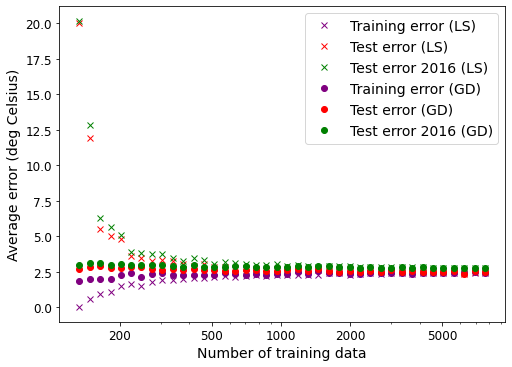

In [14]:
plt.figure(figsize=(8,6))
linstyle = 'None'
plt.plot(n_train_list,train_error_ls_vec,linestyle=linstyle,marker='x',color='purple',label="Training error (LS)")
plt.plot(n_train_list,test_error_ls_vec,linestyle=linstyle,marker='x',color='red',label="Test error (LS)")
plt.plot(n_train_list,test_2016_ls_vec,linestyle=linstyle,marker='x',color='green',label="Test error 2016 (LS)")
plt.plot(n_train_list,train_error_vec,linestyle=linstyle,marker='o',color='purple',label="Training error (GD)")
plt.plot(n_train_list,test_error_vec,linestyle=linstyle,marker='o',color='red',label="Test error (GD)")
plt.plot(n_train_list,test_2016_vec,linestyle=linstyle,marker='o',color='green',label="Test error 2016 (GD)")
# plt.ylim((-0.5,7))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Average error (deg Celsius)',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
plt.legend(fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

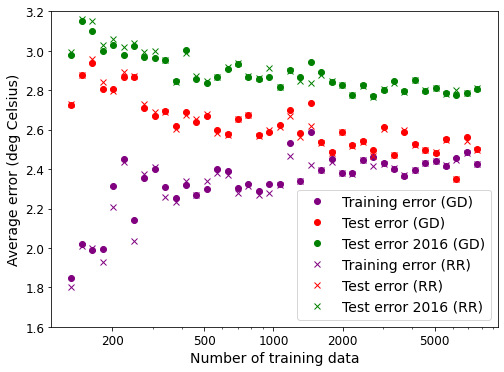

In [15]:
plt.figure(figsize=(8,6))
linstyle = 'None'
plt.plot(n_train_list,train_error_vec,linestyle=linstyle,marker='o',color='purple',label="Training error (GD)")
plt.plot(n_train_list,test_error_vec,linestyle=linstyle,marker='o',color='red',label="Test error (GD)")
plt.plot(n_train_list,test_2016_vec,linestyle=linstyle,marker='o',color='green',label="Test error 2016 (GD)")
plt.plot(n_train_list,train_error_ridge_vec,linestyle=linstyle,marker='x',color='purple',label="Training error (RR)")
plt.plot(n_train_list,test_error_ridge_vec,linestyle=linstyle,marker='x',color='red',label="Test error (RR)")
plt.plot(n_train_list,test_2016_ridge_vec,linestyle=linstyle,marker='x',color='green',label="Test error 2016 (RR)")
plt.ylim((1.6,3.2))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Average error (deg Celsius)',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
plt.legend(fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
# plt.savefig('plots/gd_yosemite_errors_rr.pdf',bbox_inches="tight")
plt.show()

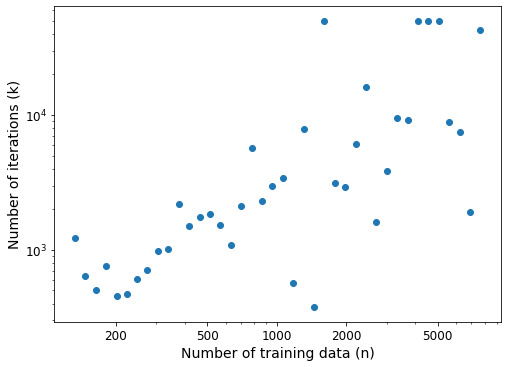

In [16]:
plt.figure(figsize=(8,6))
plt.plot(n_train_list,k_vec,marker='o',linestyle='none')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"Number of iterations (k)",fontsize=14)
plt.xlabel('Number of training data (n)',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
# plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

### coefficients after gradient descent

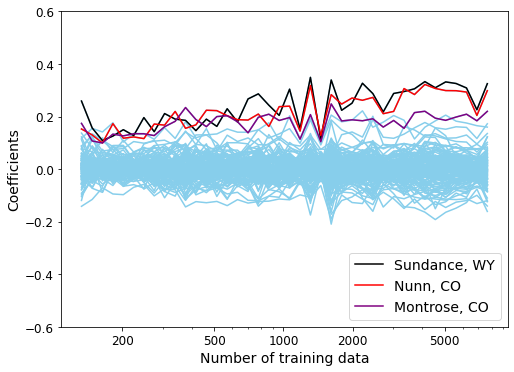

In [20]:
n_largest = 3
color_list = ['black','red','purple','brown','darkgreen']
sorted_coeffs = np.argsort(np.abs(coeffs_gd_matrix[:,-1]))
largest_coeffs = sorted_coeffs[-1:(-n_largest-1):-1]
plt.figure(figsize=(8,6))
for ind in range(n_features):
    plt.plot(n_train_list,coeffs_gd_matrix[ind,:],color='skyblue')
for ind in range(len(largest_coeffs)):
    ind_name = largest_coeffs[ind]
    if ind_name>=ind_response:
        ind_name = ind_name + 1
    aux_name = file_name_list[ind_name]
    aux_name = aux_name[14:]
    aux_name = aux_name[:-7]
    table = str.maketrans(dict.fromkeys('_0123456789'))
    aux_name = aux_name.translate(table)
    aux_name = aux_name[2:] + ", " + aux_name[:2]
    plt.plot(n_train_list,coeffs_gd_matrix[largest_coeffs[ind],:],color=color_list[ind],label=aux_name)
plt.ylim((-0.6,0.6))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Coefficients',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
# plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.legend(loc = 'upper right',bbox_to_anchor=(1.3, 1.))
plt.legend(loc = 'lower right',fontsize=14)
aux_name = file_name_list[ind_response]
aux_name = aux_name[14:]
aux_name = aux_name[:-7]
table = str.maketrans(dict.fromkeys('_0123456789'))
aux_name = aux_name.translate(table)
aux_name = aux_name[2:] + ", " + aux_name[:2]
plt.show()

### training and validation errors of the gradient-descent estimator applied to the temperature-prediction task as the iterations progress.

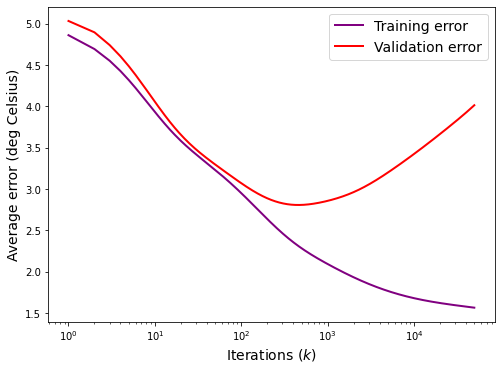

In [18]:
plt.figure(figsize=(8,6))
plt.plot(range(1,k_max),train_error_fixed_n_vec,linewidth=2,color='purple',label='Training error')
plt.plot(range(1,k_max),val_error_fixed_n_vec,linewidth=2,color='red',label='Validation error')
plt.xlabel(r"Iterations ($k$)",fontsize=14)
plt.ylabel('Average error (deg Celsius)',fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xscale('log')
plt.legend(loc = 'upper right',fontsize=14)
plt.show()

### the values of the corresponding model coefficients from the graph above

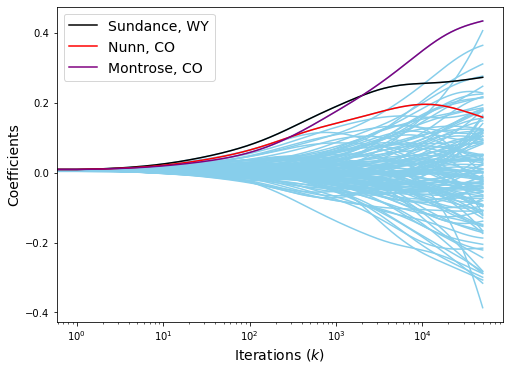

In [19]:
plt.figure(figsize=(8,6))
for ind in range(n_features):
    plt.plot(range(k_max),coeffs_fixed_n[ind,:],color='skyblue')
    plt.xscale('log')
for ind in range(len(largest_coeffs)):
    ind_name = largest_coeffs[ind]
    if ind_name>=ind_response:
        ind_name = ind_name + 1
    aux_name = file_name_list[ind_name]
    aux_name = aux_name[14:]
    aux_name = aux_name[:-7]
    table = str.maketrans(dict.fromkeys('_0123456789'))
    aux_name = aux_name.translate(table)
    aux_name = aux_name[2:] + ", " + aux_name[:2]
    plt.plot(range(k_max),coeffs_fixed_n[largest_coeffs[ind],:],color=color_list[ind],label=aux_name)
plt.xlabel(r"Iterations ($k$)",fontsize=14)
plt.ylabel('Coefficients',fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc = 'upper left',fontsize=14)
plt.xscale('log')
plt.show()